In [1]:
# REF https://www.kaggle.com/code/kooose/simple-recommendation-system
# FILE https://www.kaggle.com/saurav9786/amazon-product-reviews/download

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from wordcloud import WordCloud
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from matplotlib import cm
from statistics import mean 

In [3]:
df = pd.read_csv("ratings_Electronics (1).csv", header=None, 
                   names=["user_id", "product_id", "user_rating", "timestamp"], 
                   usecols=['user_id', 'product_id','user_rating'])
df.head()

,user_id,product_id,user_rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [4]:
df.describe()

,user_rating
count,7.824482e+06
mean,4.012337e+00
std,1.380910e+00
min,1.000000e+00
25%,3.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


In [5]:
df.isnull().sum()

user_id        0
product_id     0
user_rating    0
dtype: int64

D:\Anaconda3\envs\sd_env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='user_rating', ylabel='count'>

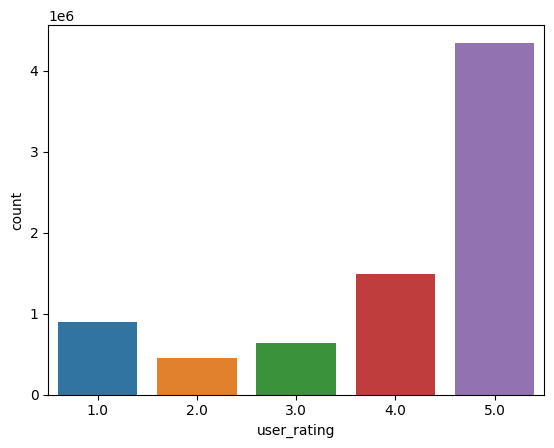

In [6]:
sns.countplot(df.user_rating)

### 전처리

In [7]:
user = pd.DataFrame(df.user_id.value_counts().values, index=df.user_id.value_counts().index)
user = user.reset_index()
user.columns = ["user_id", "cnt"]
user.head()

,user_id,cnt
0,A5JLAU2ARJ0BO,520
1,ADLVFFE4VBT8,501
2,A3OXHLG6DIBRW8,498
3,A6FIAB28IS79,431
4,A680RUE1FDO8B,406


In [8]:
user.describe()

,cnt
count,4.201696e+06
mean,1.862220e+00
std,2.885110e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,5.200000e+02


In [9]:
user.cnt.min(), user.cnt.max()

(1, 520)

In [10]:
len(user[user.cnt==1])

2881832

In [11]:
df = pd.merge(df, user, how="left", on="user_id")
df = df[df.cnt > 50]  # 후기 50 이상 남긴 고객 = 유의미
df.describe()

,user_rating,cnt
count,122171.000000,122171.000000
mean,4.262616,109.747051
std,1.058826,78.612056
min,1.000000,51.000000
25%,4.000000,62.000000
50%,5.000000,81.000000
75%,5.000000,121.000000
max,5.000000,520.000000


In [12]:
df.drop("cnt", axis=1, inplace=True)
del user 
df.shape

(122171, 3)

In [13]:
df.head()

,user_id,product_id,user_rating
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0
631,A3TAS1AG6FMBQW,0972683275,5.0


In [14]:
product = pd.DataFrame(df.product_id.value_counts().values, index=df.product_id.value_counts().index)
product = product.reset_index()
product.columns = ["product_id", "cnt"]
product.head()

,product_id,cnt
0,B0088CJT4U,204
1,B003ES5ZUU,177
2,B000N99BBC,163
3,B007WTAJTO,156
4,B00829TIEK,146


In [15]:
product.describe()

,cnt
count,47155.000000
mean,2.590839
std,5.055156
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,204.000000


In [16]:
df = pd.merge(df, product, how="left", on="product_id")
df = df[df.cnt > 30]  # 제품당 판매개수
df.describe()

,user_rating,cnt
count,11543.000000,11543.000000
mean,4.393139,66.420948
std,0.920037,39.320570
min,1.000000,31.000000
25%,4.000000,38.000000
50%,5.000000,50.000000
75%,5.000000,77.000000
max,5.000000,204.000000


In [17]:
df.head()

,user_id,product_id,user_rating,cnt
1324,A2YRX8J4WM5BRX,B00004ZCJE,5.0,70
1325,AU627A4UGIW6V,B00004ZCJE,5.0,70
1326,AR8LWDT6TUKNZ,B00004ZCJE,5.0,70
1327,AD9ZL63H0VKCZ,B00004ZCJE,5.0,70
1328,A32T2H8150OJLU,B00004ZCJE,3.0,70


In [18]:
df.drop("cnt", axis=1, inplace=True)
del product 
df.product_id.value_counts()

B0088CJT4U    204
B003ES5ZUU    177
B000N99BBC    163
B007WTAJTO    156
B00829TIEK    146
             ... 
B006LW0W5Y     31
B00005LEN4     31
B00HPM1G8Q     31
B00IVFDZBC     31
B000EVSLRO     31
Name: product_id, Length: 222, dtype: int64

In [19]:
df.head()

,user_id,product_id,user_rating
1324,A2YRX8J4WM5BRX,B00004ZCJE,5.0
1325,AU627A4UGIW6V,B00004ZCJE,5.0
1326,AR8LWDT6TUKNZ,B00004ZCJE,5.0
1327,AD9ZL63H0VKCZ,B00004ZCJE,5.0
1328,A32T2H8150OJLU,B00004ZCJE,3.0


In [20]:
df = df.reset_index()
df.drop(["index"], axis=1, inplace=True)
df.head()

,user_id,product_id,user_rating
0,A2YRX8J4WM5BRX,B00004ZCJE,5.0
1,AU627A4UGIW6V,B00004ZCJE,5.0
2,AR8LWDT6TUKNZ,B00004ZCJE,5.0
3,AD9ZL63H0VKCZ,B00004ZCJE,5.0
4,A32T2H8150OJLU,B00004ZCJE,3.0


In [21]:
most_bie_product = df.product_id.value_counts()
most_bie_product = pd.DataFrame({"user_cnt": most_bie_product.values}, index=most_bie_product.index)
most_bie_product.head()

,user_cnt
B0088CJT4U,204
B003ES5ZUU,177
B000N99BBC,163
B007WTAJTO,156
B00829TIEK,146


In [22]:
most_rating_product = df.groupby("product_id").mean().loc[:, ["user_rating"]]
most_rating_product.head()

,user_rating
product_id,
B00004ZCJE,4.242857
B00005LEN4,4.709677
B000067RT6,4.921053
B00006RVPW,4.645161
B00007E7JU,4.406780


In [23]:
most_product = pd.merge(most_bie_product, most_rating_product, how="outer", left_index=True, right_index=True)
del most_bie_product, most_rating_product

In [24]:
most_product.sort_values("user_cnt", ascending=False)[:10].loc[:, ["user_cnt"]]

,user_cnt
B0088CJT4U,204
B003ES5ZUU,177
B000N99BBC,163
B007WTAJTO,156
B00829TIEK,146
B008DWCRQW,135
B00829THK0,132
B002R5AM7C,127
B004CLYEDC,117
B002SZEOLG,108


In [25]:
most_product.sort_values("user_rating", ascending=False)[:10].loc[:, ["user_rating"]]

,user_rating
B0052SCU8U,4.979167
B001TH7T2U,4.925000
B000067RT6,4.921053
B00BQ4F9ZA,4.906977
B004GF8TIK,4.903226
B00IVFDZBC,4.903226
B0036Q7MV0,4.894737
B0019EHU8G,4.894118
B00316263Y,4.885714
B0000BZL1P,4.883721


In [28]:
most_product.head()

,user_cnt,user_rating
B00004ZCJE,70,4.242857
B00005LEN4,31,4.709677
B000067RT6,38,4.921053
B00006RVPW,31,4.645161
B00007E7JU,59,4.406780


In [26]:
piv = df.pivot_table(values=["user_rating"], columns=["product_id"], index=["user_id"], fill_value=0)
piv.head()

user_rating                                              \
product_id      B00004ZCJE B00005LEN4 B000067RT6 B00006RVPW B00007E7JU   
user_id                                                                  
A100UD67AHFODS           0          0          0          0          0   
A100WO06OQR8BQ           0          0          0          5          0   
A105S56ODHGJEK           0          0          0          0          0   
A105TOJ6LTVMBG           0          0          0          0          0   
A10AFVU66A79Y1           0          0          0          0          0   

                                                                       ...  \
product_id     B00007KDVI B00009XVCZ B0000BZL1P B00017LSPI B0002L5R78  ...   
user_id                                                                ...   
A100UD67AHFODS          0          0          0          0          0  ...   
A100WO06OQR8BQ          0          0          0          0          1  ...   
A105S56ODHGJEK          0          0          0          0          0  ...   
A105TOJ6LTVMBG          0          0          0          0          0  ...   
A10AFVU66A79Y1          0          0          0          0          0  ...   

                                                                       \
product_id     B00G6CLNCK B00HFAEBWG B00HFRWWAM B00HPM1FZ0 B00HPM1G8Q   
user_id                                                                 
A100UD67AHFODS          0          0          0          0          0   
A100WO06OQR8BQ          0          0          0          0          0   
A105S56ODHGJEK          5          0          0          0          0   
A105TOJ6LTVMBG          0          0          0          0          0   
A10AFVU66A79Y1          0          0          0          0          0   

                                                                       
product_id     B00HSQAIQU B00IL7B2YM B00IVFDZBC B00JC5Y6WM B00JP12170  
user_id                                                                
A100UD67AHFODS          0          0          0          0          0  
A100WO06OQR8BQ          1          0          0          0          0  
A105S56ODHGJEK          0          0          5          5          0  
A105TOJ6LTVMBG          0          0          0          0          0  
A10AFVU66A79Y1          0          0          0          0          0  

[5 rows x 222 columns]

In [29]:
s = MinMaxScaler(feature_range=(0.0, 1.0))
piv_scaler = s.fit_transform(piv)
piv_scaler = pd.DataFrame(piv_scaler, index=piv.index, columns=piv.columns)
piv_scaler.head()

D:\Anaconda3\envs\sd_env\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
D:\Anaconda3\envs\sd_env\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


user_rating                                              \
product_id      B00004ZCJE B00005LEN4 B000067RT6 B00006RVPW B00007E7JU   
user_id                                                                  
A100UD67AHFODS         0.0        0.0        0.0        0.0        0.0   
A100WO06OQR8BQ         0.0        0.0        0.0        1.0        0.0   
A105S56ODHGJEK         0.0        0.0        0.0        0.0        0.0   
A105TOJ6LTVMBG         0.0        0.0        0.0        0.0        0.0   
A10AFVU66A79Y1         0.0        0.0        0.0        0.0        0.0   

                                                                       ...  \
product_id     B00007KDVI B00009XVCZ B0000BZL1P B00017LSPI B0002L5R78  ...   
user_id                                                                ...   
A100UD67AHFODS        0.0        0.0        0.0        0.0        0.0  ...   
A100WO06OQR8BQ        0.0        0.0        0.0        0.0        0.2  ...   
A105S56ODHGJEK        0.0        0.0        0.0        0.0        0.0  ...   
A105TOJ6LTVMBG        0.0        0.0        0.0        0.0        0.0  ...   
A10AFVU66A79Y1        0.0        0.0        0.0        0.0        0.0  ...   

                                                                       \
product_id     B00G6CLNCK B00HFAEBWG B00HFRWWAM B00HPM1FZ0 B00HPM1G8Q   
user_id                                                                 
A100UD67AHFODS        0.0        0.0        0.0        0.0        0.0   
A100WO06OQR8BQ        0.0        0.0        0.0        0.0        0.0   
A105S56ODHGJEK        1.0        0.0        0.0        0.0        0.0   
A105TOJ6LTVMBG        0.0        0.0        0.0        0.0        0.0   
A10AFVU66A79Y1        0.0        0.0        0.0        0.0        0.0   

                                                                       
product_id     B00HSQAIQU B00IL7B2YM B00IVFDZBC B00JC5Y6WM B00JP12170  
user_id                                                                
A100UD67AHFODS        0.0        0.0        0.0        0.0        0.0  
A100WO06OQR8BQ        0.2        0.0        0.0        0.0        0.0  
A105S56ODHGJEK        0.0        0.0        1.0        1.0        0.0  
A105TOJ6LTVMBG        0.0        0.0        0.0        0.0        0.0  
A10AFVU66A79Y1        0.0        0.0        0.0        0.0        0.0  

[5 rows x 222 columns]

### product, user별 cosine유사도 위한 데이터 정리

In [31]:
piv_sparse = sp.sparse.csr_matrix(piv_scaler.values)
col = [c for _, c in piv.columns]

product = cosine_similarity(piv_sparse.T)
product = pd.DataFrame(product, columns=col, index=col)

user = cosine_similarity(piv_sparse)
user = pd.DataFrame(user, columns=piv.index, index=piv.index)

In [32]:
product

,B00004ZCJE,B00005LEN4,B000067RT6,B00006RVPW,B00007E7JU,B00007KDVI,B00009XVCZ,B0000BZL1P,B00017LSPI,B0002L5R78,...,B00G6CLNCK,B00HFAEBWG,B00HFRWWAM,B00HPM1FZ0,B00HPM1G8Q,B00HSQAIQU,B00IL7B2YM,B00IVFDZBC,B00JC5Y6WM,B00JP12170
B00004ZCJE,1.000000,0.105744,0.000000,0.051985,0.176726,0.000000,0.068259,0.128014,0.098479,0.076035,...,0.031961,0.013624,0.046274,0.000000,0.041918,0.024179,0.086171,0.025037,0.000000,0.047969
B00005LEN4,0.105744,1.000000,0.000000,0.000000,0.048845,0.000000,0.031029,0.129732,0.000000,0.049564,...,0.000000,0.031379,0.046339,0.000000,0.000000,0.000000,0.000000,0.000000,0.033497,0.025996
B000067RT6,0.000000,0.000000,1.000000,0.124810,0.033001,0.000000,0.037736,0.025612,0.025700,0.021527,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023279,0.000000
B00006RVPW,0.051985,0.000000,0.124810,1.000000,0.043543,0.000000,0.049790,0.029569,0.029670,0.029824,...,0.000000,0.000000,0.023236,0.000000,0.000000,0.067020,0.000000,0.000000,0.000000,0.020857
B00007E7JU,0.176726,0.048845,0.033001,0.043543,1.000000,0.032191,0.182429,0.103651,0.157800,0.075103,...,0.060234,0.000000,0.115856,0.000000,0.043888,0.000000,0.000000,0.052427,0.020303,0.044315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B00HSQAIQU,0.024179,0.000000,0.000000,0.067020,0.000000,0.045980,0.017369,0.022005,0.000000,0.084154,...,0.046149,0.095140,0.157357,0.046102,0.000000,1.000000,0.049912,0.051644,0.000000,0.052141
B00IL7B2YM,0.086171,0.000000,0.000000,0.000000,0.000000,0.131029,0.014952,0.035518,0.000000,0.047765,...,0.031924,0.068041,0.072568,0.000000,0.143552,0.049912,1.000000,0.000000,0.000000,0.070460
B00IVFDZBC,0.025037,0.000000,0.000000,0.000000,0.052427,0.049253,0.029974,0.000000,0.000000,0.023939,...,0.385701,0.083359,0.058192,0.071605,0.071947,0.051644,0.000000,1.000000,0.291226,0.040179
B00JC5Y6WM,0.000000,0.033497,0.023279,0.000000,0.020303,0.031790,0.052236,0.000000,0.022136,0.046354,...,0.302373,0.036684,0.056340,0.109381,0.100615,0.000000,0.000000,0.291226,1.000000,0.000000


In [34]:
def find_similar_product(product_name: str, n=10):
    sim_product = product[product_name].sort_values(ascending=False)[1:n+1]
    df = pd.DataFrame(sim_product.values, index=sim_product.index, columns=["cosine_similar"])
    df.index.name = "product_id"
    return df 

In [36]:
random_product_name = np.random.choice(product.index, 1)[0]
find_similar_product(random_product_name)

,cosine_similar
product_id,
B00BOHNYTW,0.209814
B0088CJT4U,0.192545
B004CLYEDC,0.185189
B00829THK0,0.181905
B0079UAT0A,0.181413
B004CLYEE6,0.176982
B005QCDY50,0.165134
B004CLYEH8,0.162551
B000N99BBC,0.158789


In [33]:
user

user_id,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,1.000000,0.000000,0.000000,0.192879,0.102329,0.000000,0.331133,0.102062,0.092026,0.163299,...,0.000000,0.000000,0.000000,0.22500,0.269434,0.000000,0.000000,0.286351,0.000000,0.000000
A100WO06OQR8BQ,0.000000,1.000000,0.066676,0.000000,0.063192,0.058683,0.136325,0.000000,0.000000,0.000000,...,0.000000,0.023894,0.128370,0.00000,0.085326,0.130189,0.000000,0.157185,0.000000,0.033615
A105S56ODHGJEK,0.000000,0.066676,1.000000,0.000000,0.103579,0.252492,0.000000,0.000000,0.134137,0.000000,...,0.000000,0.000000,0.087068,0.00000,0.053706,0.000000,0.000000,0.012367,0.116881,0.000000
A105TOJ6LTVMBG,0.192879,0.000000,0.000000,1.000000,0.000000,0.000000,0.255475,0.000000,0.000000,0.000000,...,0.314970,0.000000,0.000000,0.00000,0.159902,0.000000,0.000000,0.294566,0.000000,0.000000
A10AFVU66A79Y1,0.102329,0.063192,0.103579,0.000000,1.000000,0.113952,0.000000,0.000000,0.000000,0.083551,...,0.000000,0.000000,0.154035,0.23024,0.224808,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZBXKUH4AIW3X,0.000000,0.130189,0.000000,0.000000,0.000000,0.000000,0.000000,0.129099,0.116405,0.258199,...,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.120736,0.000000,0.000000
AZCE11PSTCH1L,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.269975,0.000000,0.000000
AZMY6E8B52L2T,0.286351,0.157185,0.012367,0.294566,0.000000,0.000000,0.166884,0.000000,0.070272,0.140283,...,0.311740,0.000000,0.000000,0.00000,0.079131,0.120736,0.269975,1.000000,0.110217,0.311740


In [35]:
def find_similar_user(user_id: str, n=10):
    sim_user = user[user_id].sort_values(ascending=False)[1:n+1]
    df = pd.DataFrame(sim_user.values, index=sim_user.index, columns=["cosine_similar"])
    df.index.name = "user_id"
    return df 

In [37]:
random_user_id = np.random.choice(user.index, 1)[0]
find_similar_user(random_user_id)

,cosine_similar
user_id,
AU3GYRAKBUAEU,0.648708
A1XK4VP74IB9TQ,0.577350
A2OT3PDH1AWLTG,0.577350
A19XPAWSWDRI3B,0.502519
A3AZI828WJN1CD,0.440732
A3UR2N0ATGBCU8,0.408248
A2YRX8J4WM5BRX,0.408248
A3D0UM4ZD2CMAW,0.408248
A291XTI6NO7DEG,0.408248


### 유사 사용자 특징 기반 상품 추천
+ 데이터가 적은 초기 상태 : cold start(추천 시스템이 새/어떤 유저들에 대한 충분한 정보가 없는 상태에서 적절한 제품 추천 불가한 문제) 발생

In [38]:
# 유사 사용자별 상품 데이터 집계 후, 빈도수 상위 상품을 추천. 
def recommend(user_id: str, n=10):
    sim_user_df = find_similar_user(user_id, n)
    product2count = {}
    for sim, sim_user in zip(sim_user_df.cosine_similar, sim_user_df.index):
        product = df[df.user_id == sim_user]["product_id"].values
        for p in product:
            if p not in product2count:
                product2count[p] = 1 
            else:
                product2count[p] += 1
    df_ = pd.DataFrame({"product": [k for k, _ in product2count.items()], 
                      "recommend": [v for _, v in product2count.items()]}).sort_values("recommend", ascending=False)[:n]
    return df_.groupby("product").sum().sort_values("recommend", ascending=False)

In [40]:
recommend(random_user_id)

,recommend
product,
B005CT56F8,7
B005DKZTMG,5
B002WE6D44,2
B00834SJSK,2
B00004ZCJE,1
B000EVSLRO,1
B0043T7FXE,1
B005HMKKH4,1
B007WTAJTO,1


In [39]:
# 유사 사용자별 최고 평점 준 상품 집계 후, 사용자간 유사도 + 평점 기준으로 평점 예측. 
def predict_recommend_rating(user_id: str, n=10):
    sim_user_df = find_similar_user(user_id, n)
    df_list = []
    for sim, sim_user in zip(sim_user_df.cosine_similar, sim_user_df.index):
        most_product = piv.loc[sim_user, :].sort_values(ascending=False)
        # 최고 평점 제품 1개만 하기보다는 여러개 기준으로 계산하는게 더 정확함 
        most_product_id = most_product.index[0][1]
        most_product_rating = most_product.values[0]
        # 평점 예측
        predict_rating = (sim*most_product_rating)/sim 
        df_list.append({"product_id": most_product_id, "predict_rating": predict_rating})
    df_ = pd.DataFrame(df_list).sort_values("predict_rating", ascending=False)[:n]
    # 전체 사용자 예측평점의 평균 ??? 
    return df_.groupby("product_id").mean().sort_values("predict_rating", ascending=False)

In [41]:
predict_recommend_rating(random_user_id)

,predict_rating
product_id,
B00004ZCJE,5.000000
B005CT56F8,5.000000
B005DKZTMG,4.666667


### k-means 클러스터 분석
+ 유저와 상품의 평가치의 관계성으로부터 비선형에 의한 차원 삭감을 한다.
+ 비선형 클러스터링을 수행하여 각 클러스터의 상품 구매 수를 누적합니다.

In [42]:
piv_scaler.head()

user_rating                                              \
product_id      B00004ZCJE B00005LEN4 B000067RT6 B00006RVPW B00007E7JU   
user_id                                                                  
A100UD67AHFODS         0.0        0.0        0.0        0.0        0.0   
A100WO06OQR8BQ         0.0        0.0        0.0        1.0        0.0   
A105S56ODHGJEK         0.0        0.0        0.0        0.0        0.0   
A105TOJ6LTVMBG         0.0        0.0        0.0        0.0        0.0   
A10AFVU66A79Y1         0.0        0.0        0.0        0.0        0.0   

                                                                       ...  \
product_id     B00007KDVI B00009XVCZ B0000BZL1P B00017LSPI B0002L5R78  ...   
user_id                                                                ...   
A100UD67AHFODS        0.0        0.0        0.0        0.0        0.0  ...   
A100WO06OQR8BQ        0.0        0.0        0.0        0.0        0.2  ...   
A105S56ODHGJEK        0.0        0.0        0.0        0.0        0.0  ...   
A105TOJ6LTVMBG        0.0        0.0        0.0        0.0        0.0  ...   
A10AFVU66A79Y1        0.0        0.0        0.0        0.0        0.0  ...   

                                                                       \
product_id     B00G6CLNCK B00HFAEBWG B00HFRWWAM B00HPM1FZ0 B00HPM1G8Q   
user_id                                                                 
A100UD67AHFODS        0.0        0.0        0.0        0.0        0.0   
A100WO06OQR8BQ        0.0        0.0        0.0        0.0        0.0   
A105S56ODHGJEK        1.0        0.0        0.0        0.0        0.0   
A105TOJ6LTVMBG        0.0        0.0        0.0        0.0        0.0   
A10AFVU66A79Y1        0.0        0.0        0.0        0.0        0.0   

                                                                       
product_id     B00HSQAIQU B00IL7B2YM B00IVFDZBC B00JC5Y6WM B00JP12170  
user_id                                                                
A100UD67AHFODS        0.0        0.0        0.0        0.0        0.0  
A100WO06OQR8BQ        0.2        0.0        0.0        0.0        0.0  
A105S56ODHGJEK        0.0        0.0        1.0        1.0        0.0  
A105TOJ6LTVMBG        0.0        0.0        0.0        0.0        0.0  
A10AFVU66A79Y1        0.0        0.0        0.0        0.0        0.0  

[5 rows x 222 columns]

D:\Anaconda3\envs\sd_env\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
D:\Anaconda3\envs\sd_env\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
D:\Anaconda3\envs\sd_env\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


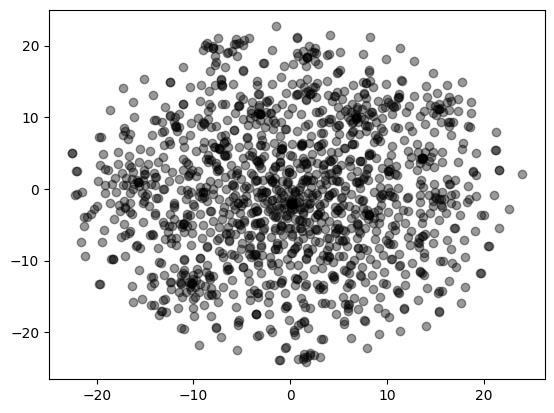

In [46]:
tsne = TSNE(n_components=2, random_state=0).fit_transform(piv_scaler)
plt.scatter(tsne[:, 0], tsne[:, 1], c=(0, 0, 0), alpha=0.4)
plt.show()

In [47]:
km = KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(tsne)
cluster_labels = np.unique(y_km)       # y_km 요소 중 중복값 제거
n_clusters=cluster_labels.shape[0]     # set length of array => 3 (n_clusters)

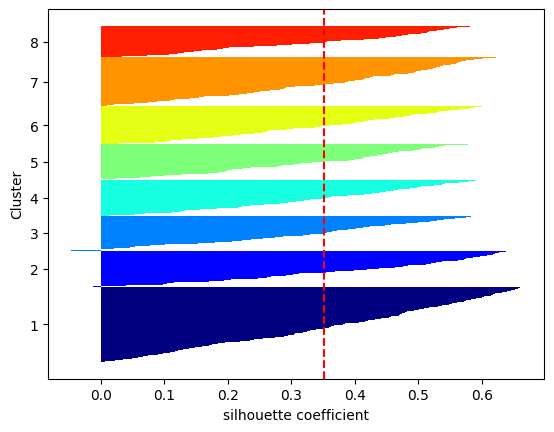

In [48]:
# calculate silhouette coefficient
silhouette_vals = silhouette_samples(tsne,y_km,metric='euclidean')  
# Silhouette coefficient calculation with sample data, cluster number, Euclidean distance
y_ax_lower, y_ax_upper= 0,0
yticks = []

for i,c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km==c]      # cluster_labelsには 0,1,2が入っている（enumerateなのでiにも0,1,2が入ってる（たまたま））
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)              # sum of samples per cluster = max y-axis value
        color = cm.jet(float(i)/n_clusters)               # create color val
        plt.barh(range(y_ax_lower,y_ax_upper),            
                         c_silhouette_vals,               # bar width
                         height=1.0,                      
                         edgecolor='none',                
                         color=color)                     
        yticks.append((y_ax_lower+y_ax_upper)/2)          # cluster lable position
        y_ax_lower += len(c_silhouette_vals)              # add bar width to base val

silhouette_avg = np.mean(silhouette_vals)                 
plt.axvline(silhouette_avg,color="red",linestyle="--")    # show coeff mean as line
plt.yticks(yticks,cluster_labels + 1)                     # cluster level
plt.ylabel('Cluster')
plt.xlabel('silhouette coefficient')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
D:\Anaconda3\envs\sd_env\lib\site-packages\ipykernel_launcher.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its l

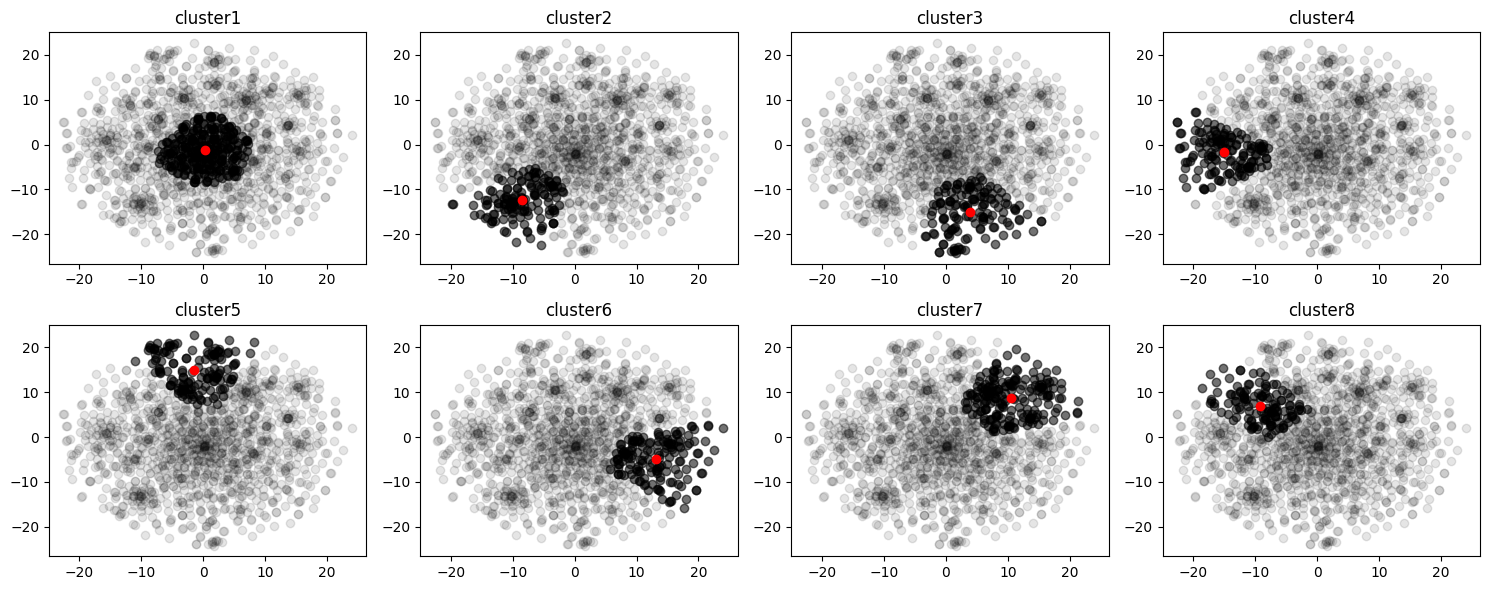

In [49]:
center = km.cluster_centers_

fig, axes = plt.subplots(2, 4 , figsize=(15, 6))
ax = axes.ravel()
for i in range(8):
    ax[i].scatter(x=tsne[:, 0],y =tsne[:, 1], c=(0, 0, 0), alpha=0.1)
    ax[i].scatter(x=tsne[:, 0][y_km == i], y=tsne[:, 1][y_km == i], c=(0, 0, 0), alpha=0.5)
    ax[i].plot(center[i, 0], center[i, 1], "bo", c="r")
    ax[i].set_title(f"cluster{i+1}")
plt.tight_layout()

In [50]:
cluster = pd.DataFrame({"user_id": piv_scaler.index, "cluster": y_km})
df = pd.merge(df, cluster, how="left", on="user_id")
df.head()

,user_id,product_id,user_rating,cluster
0,A2YRX8J4WM5BRX,B00004ZCJE,5.0,4
1,AU627A4UGIW6V,B00004ZCJE,5.0,4
2,AR8LWDT6TUKNZ,B00004ZCJE,5.0,4
3,AD9ZL63H0VKCZ,B00004ZCJE,5.0,4
4,A32T2H8150OJLU,B00004ZCJE,3.0,7


In [51]:
# 빈도수 상위의 제폼번호
def show_cloud(product, name):
    word = WordCloud().generate_from_frequencies(product)
    plt.imshow(word)
    plt.axis("off")
    plt.title(f"cluster: {str(name)}")
    plt.show()
    plt.savefig(f"cluster{str(name)}.png")


In [52]:
# 클러스터 간 상품 구매 수의 누적 및 평가 평균 상품명의 테이블이 있으면 보다 해석성이 늘어난다.??
def cluster_analysis(cluster, names=0):
    product = cluster["product_id"].tolist()
    rating = cluster["user_rating"].tolist()
    product2count = {}
    mean_rating = []
    for p, r in zip(product, rating):
        p = p.strip()
        if p not in product2count:
            product2count[p] = 1
        else:
            product2count[p] += 1 
        mean_rating.append(r)
        
    show_cloud(product2count, names)
    return {"user_rating": mean(mean_rating)}

In [53]:
c0 = df[df.cluster == 0].drop("cluster", axis=1)
c1 = df[df.cluster == 1].drop("cluster", axis=1)
c2 = df[df.cluster == 2].drop("cluster", axis=1)
c3 = df[df.cluster == 3].drop("cluster", axis=1)
c4 = df[df.cluster == 4].drop("cluster", axis=1)
c5 = df[df.cluster == 5].drop("cluster", axis=1)
c6 = df[df.cluster == 6].drop("cluster", axis=1)
c7 = df[df.cluster == 7].drop("cluster", axis=1)

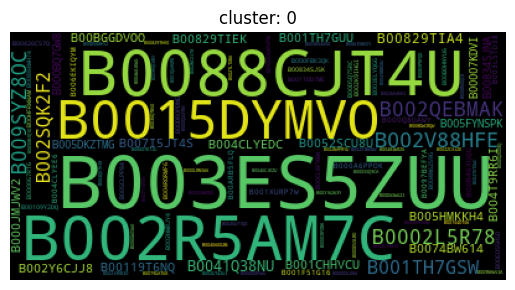

{'user_rating': 4.2827586206896555}

<Figure size 640x480 with 0 Axes>

In [54]:
cluster_analysis(c0, 0)

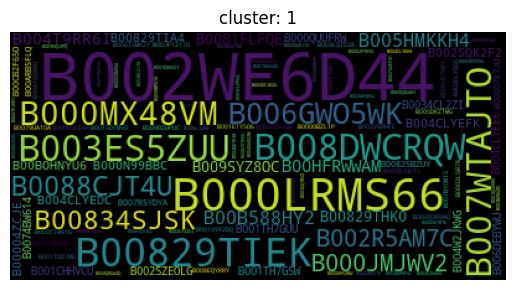

{'user_rating': 4.426481909160893}

<Figure size 640x480 with 0 Axes>

In [55]:
cluster_analysis(c1, 1)

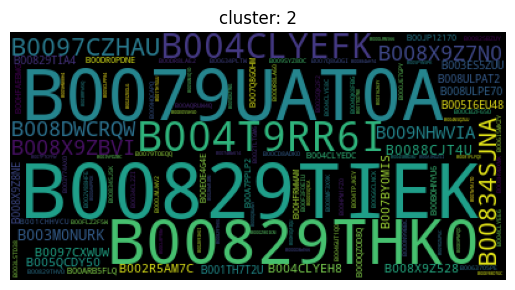

{'user_rating': 4.332329921733895}

<Figure size 640x480 with 0 Axes>

In [56]:
cluster_analysis(c2, 2)

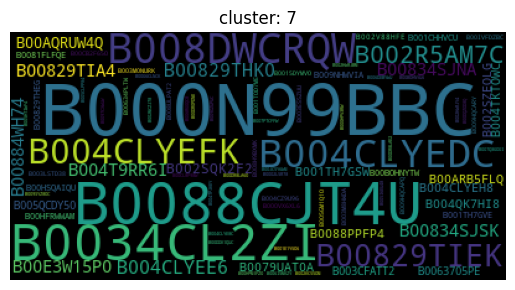

{'user_rating': 4.339034819792303}

<Figure size 640x480 with 0 Axes>

In [57]:
cluster_analysis(c3, 7)